# Training the Neural Network

## check for torch cuda

In [72]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Prepare Dataset

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sympy import im
import torch
import pandas as pd
import os
import openpyxl
df = pd.read_pickle('data/trainingData.pkl')
df["GKID"] = df["GKID"].astype(float).astype(int).astype(str).str.zfill(8)

In [ ]:
gkid_series = df["GKID"].copy()
y = df['preis_miet_best'].values
df = df.drop(columns=['preis_miet_best','Gastronomy','All_Buildings','Cycleways','Water_Bodies','Fast_Food','Schools','Green_Areas','Building_Types','v_gsm','Buildings_With_Height_Levels','ko_kasskred','v_breitb50','v_lte','Bio-Läden','Landuse','p_markt','p_apo','bev_binw','heiz_wohn_best','v_5g','p_poli','fl_landw','p_freibad','v_breitb1000','Kindergartens','Health','Playgrounds','p_harzt','p_grunds','pfl_ambu','eauto','v_lte','st_einnkr','p_notfall','beschq_insg','Bio_Shops','mitgl_sportv','erw_mini','straft','elterng_v','p_ozmz_oev','kbetr_ue3','bev_entw','p_nelade','bquali_unifh','p_ozmz_miv','p_sek_2','kinder_bg','All_Highways','GKID','sozsich','wohn_leer','teilz_insg'], axis=1)
X = df.values
feature_names = df.columns.tolist()

0    01001000
1    01002000
2    01003000
3    01004000
4    01051000
Name: GKID, dtype: object


0        01001000
1        01002000
2        01003000
3        01004000
4        01051000
           ...   
10949    16077000
10950    16077000
10951    16077000
10955    16077000
10956    16077000
Name: GKID, Length: 9883, dtype: object

In [ ]:

# Split
X_train_unscaled, X_val_unscaled, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_unscaled)
X_val = scaler.transform(X_val_unscaled)

# Torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)  # use float32 for regression targets
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)


##  Create Dataset and DataLoader

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

## Define the Model Class

In [ ]:
import torch.nn as nn

class TabularNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout_rate, activation_fn):
        super(TabularNN, self).__init__()
        layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, h_dim))
            if activation_fn == 'relu':
                layers.append(nn.ReLU())
            elif activation_fn == 'tanh':
                layers.append(nn.Tanh())
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = h_dim
        layers.append(nn.Linear(prev_dim, 1))  # output 1 value for regression
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)  # output shape: (batch_size,)



##  Define Training and Evaluation Functions

In [ ]:
def train_one_epoch(model, optimizer, criterion, dataloader, device):
    model.train()
    total_loss = 0
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.float().to(device)
        #print(f"X_batch device inside train_one_epoch: {X_batch.device}") # Debugging line to check device
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)
    return total_loss / len(dataloader.dataset)

def evaluate(model, dataloader, device):
    model.eval()
    criterion = torch.nn.MSELoss(reduction="sum")  # Sum so we can compute RMSE ourselves
    total_squared_error = 0.0
    total_samples = 0

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.float().to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_squared_error += loss.item()
            total_samples += y_batch.size(0)

    mse = total_squared_error / total_samples
    rmse = mse ** 0.5
    return rmse



## Define the Optuna Objective Function

In [ ]:

import optuna

def objective(trial):
    try:
        hidden_dim1 = trial.suggest_int("hidden_dim1", 32, 256)
        hidden_dim2 = trial.suggest_int("hidden_dim2", 32, 128)
        dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)
        lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
        batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
        activation_fn = trial.suggest_categorical("activation_fn", ["relu", "tanh"])

        model = TabularNN(
            input_dim=49,
            hidden_dims=[hidden_dim1, hidden_dim2],
            dropout_rate=dropout_rate,
            activation_fn=activation_fn,
        ).to(device)

        # DataLoader
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = torch.nn.MSELoss()

        for epoch in range(100):
            train_one_epoch(model, optimizer, criterion, train_loader, device)
            val_rmse = evaluate(model, val_loader, device)
            trial.report(val_rmse, epoch)

            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

        return val_rmse

    except Exception as e:
        print(f"Trial failed with exception: {e}")
        raise  # Reraise so Optuna logs the failure, does not work for now...

## Launch the Optimization

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=500)

[I 2025-07-09 21:48:15,358] A new study created in memory with name: no-name-98200711-c208-4204-bf92-e5a4f438d844
[I 2025-07-09 21:48:33,575] Trial 0 finished with value: 0.46380607155857695 and parameters: {'hidden_dim1': 64, 'hidden_dim2': 106, 'dropout_rate': 0.30889469242800915, 'lr': 0.0038701818486956718, 'batch_size': 64, 'activation_fn': 'tanh'}. Best is trial 0 with value: 0.46380607155857695.
[I 2025-07-09 21:49:05,939] Trial 1 finished with value: 0.4623572547570705 and parameters: {'hidden_dim1': 241, 'hidden_dim2': 128, 'dropout_rate': 0.2845558121843996, 'lr': 0.0002950088436753448, 'batch_size': 32, 'activation_fn': 'tanh'}. Best is trial 1 with value: 0.4623572547570705.
[I 2025-07-09 21:49:37,490] Trial 2 finished with value: 0.5072192360110251 and parameters: {'hidden_dim1': 49, 'hidden_dim2': 112, 'dropout_rate': 0.28731834089600483, 'lr': 0.0005783037098162803, 'batch_size': 32, 'activation_fn': 'tanh'}. Best is trial 1 with value: 0.4623572547570705.
[I 2025-07-09 

Trial failed with exception: 
Trial failed with exception: 


[I 2025-07-09 21:50:34,583] Trial 8 pruned. 


Trial failed with exception: 


[I 2025-07-09 21:50:38,039] Trial 9 pruned. 
[I 2025-07-09 21:50:38,222] Trial 10 pruned. 


Trial failed with exception: 
Trial failed with exception: 


[I 2025-07-09 21:50:38,537] Trial 11 pruned. 


Trial failed with exception: 


[I 2025-07-09 21:51:09,867] Trial 12 finished with value: 0.42326252361807654 and parameters: {'hidden_dim1': 206, 'hidden_dim2': 88, 'dropout_rate': 0.17271379807599965, 'lr': 0.0020483142961018335, 'batch_size': 32, 'activation_fn': 'tanh'}. Best is trial 12 with value: 0.42326252361807654.
[I 2025-07-09 21:51:41,928] Trial 13 finished with value: 0.4279657727774139 and parameters: {'hidden_dim1': 187, 'hidden_dim2': 87, 'dropout_rate': 0.16999748192518255, 'lr': 0.001994170363956557, 'batch_size': 32, 'activation_fn': 'tanh'}. Best is trial 12 with value: 0.42326252361807654.
[I 2025-07-09 21:52:13,605] Trial 14 finished with value: 0.43367707677175843 and parameters: {'hidden_dim1': 194, 'hidden_dim2': 91, 'dropout_rate': 0.18561478147049093, 'lr': 0.0019232050101623598, 'batch_size': 32, 'activation_fn': 'tanh'}. Best is trial 12 with value: 0.42326252361807654.
[I 2025-07-09 21:52:14,239] Trial 15 pruned. 


Trial failed with exception: 


[I 2025-07-09 21:52:46,567] Trial 16 finished with value: 0.4016946992116564 and parameters: {'hidden_dim1': 194, 'hidden_dim2': 99, 'dropout_rate': 0.128170817087238, 'lr': 0.0021177052956908395, 'batch_size': 32, 'activation_fn': 'tanh'}. Best is trial 16 with value: 0.4016946992116564.
[I 2025-07-09 21:53:18,023] Trial 17 finished with value: 0.4174895092365024 and parameters: {'hidden_dim1': 213, 'hidden_dim2': 100, 'dropout_rate': 0.10170438758156802, 'lr': 0.0028598843783022862, 'batch_size': 32, 'activation_fn': 'tanh'}. Best is trial 16 with value: 0.4016946992116564.
[I 2025-07-09 21:53:18,152] Trial 18 pruned. 


Trial failed with exception: 


[I 2025-07-09 21:53:19,129] Trial 19 pruned. 


Trial failed with exception: 


[I 2025-07-09 21:53:19,761] Trial 20 pruned. 


Trial failed with exception: 


[I 2025-07-09 21:53:20,097] Trial 21 pruned. 


Trial failed with exception: 


[I 2025-07-09 21:53:20,723] Trial 22 pruned. 


Trial failed with exception: 


[I 2025-07-09 21:53:22,030] Trial 23 pruned. 


Trial failed with exception: 


[I 2025-07-09 21:53:22,356] Trial 24 pruned. 
[I 2025-07-09 21:53:22,480] Trial 25 pruned. 


Trial failed with exception: 
Trial failed with exception: 


[I 2025-07-09 21:53:22,807] Trial 26 pruned. 


Trial failed with exception: 


[I 2025-07-09 21:53:54,497] Trial 27 finished with value: 0.4069156688478825 and parameters: {'hidden_dim1': 110, 'hidden_dim2': 84, 'dropout_rate': 0.00046554538172782767, 'lr': 0.0013183996436083368, 'batch_size': 32, 'activation_fn': 'tanh'}. Best is trial 16 with value: 0.4016946992116564.
[I 2025-07-09 21:53:55,144] Trial 28 pruned. 


Trial failed with exception: 


[I 2025-07-09 21:53:55,375] Trial 29 pruned. 


Trial failed with exception: 


[I 2025-07-09 21:53:55,701] Trial 30 pruned. 


Trial failed with exception: 


[I 2025-07-09 21:53:56,337] Trial 31 pruned. 


Trial failed with exception: 


[I 2025-07-09 21:53:56,667] Trial 32 pruned. 


Trial failed with exception: 


[I 2025-07-09 21:53:57,329] Trial 33 pruned. 


Trial failed with exception: 


[I 2025-07-09 21:54:29,560] Trial 34 finished with value: 0.4324131536470368 and parameters: {'hidden_dim1': 113, 'hidden_dim2': 70, 'dropout_rate': 0.08415679879679178, 'lr': 0.00533747323370021, 'batch_size': 32, 'activation_fn': 'tanh'}. Best is trial 16 with value: 0.4016946992116564.
[I 2025-07-09 21:54:30,205] Trial 35 pruned. 


Trial failed with exception: 


[I 2025-07-09 21:54:30,540] Trial 36 pruned. 


Trial failed with exception: 
Trial failed with exception: 


[I 2025-07-09 21:54:30,727] Trial 37 pruned. 
[I 2025-07-09 21:55:02,310] Trial 38 finished with value: 0.41059265016208907 and parameters: {'hidden_dim1': 179, 'hidden_dim2': 61, 'dropout_rate': 0.0646636556947101, 'lr': 0.003516010927241863, 'batch_size': 32, 'activation_fn': 'tanh'}. Best is trial 16 with value: 0.4016946992116564.
[I 2025-07-09 21:55:02,846] Trial 39 pruned. 
[I 2025-07-09 21:55:02,970] Trial 40 pruned. 


Trial failed with exception: 
Trial failed with exception: 


[I 2025-07-09 21:55:03,323] Trial 41 pruned. 


Trial failed with exception: 


[I 2025-07-09 21:55:03,713] Trial 42 pruned. 


Trial failed with exception: 


[I 2025-07-09 21:55:04,093] Trial 43 pruned. 


Trial failed with exception: 


[I 2025-07-09 21:55:36,148] Trial 44 finished with value: 0.39696699972419713 and parameters: {'hidden_dim1': 212, 'hidden_dim2': 73, 'dropout_rate': 0.003289116101740208, 'lr': 0.0033864997071860357, 'batch_size': 32, 'activation_fn': 'tanh'}. Best is trial 44 with value: 0.39696699972419713.
[I 2025-07-09 21:56:08,240] Trial 45 finished with value: 0.3949822036956368 and parameters: {'hidden_dim1': 246, 'hidden_dim2': 65, 'dropout_rate': 0.006696587104238742, 'lr': 0.0045747981880219215, 'batch_size': 32, 'activation_fn': 'tanh'}. Best is trial 45 with value: 0.3949822036956368.
[I 2025-07-09 21:56:27,140] Trial 46 finished with value: 0.4482890812863363 and parameters: {'hidden_dim1': 255, 'hidden_dim2': 70, 'dropout_rate': 0.009041712249552152, 'lr': 0.007215659509560829, 'batch_size': 64, 'activation_fn': 'tanh'}. Best is trial 45 with value: 0.3949822036956368.
[I 2025-07-09 21:56:27,487] Trial 47 pruned. 


Trial failed with exception: 


[I 2025-07-09 21:56:33,170] Trial 48 pruned. 


Trial failed with exception: 


[I 2025-07-09 21:57:04,748] Trial 49 finished with value: 0.43022158367728014 and parameters: {'hidden_dim1': 139, 'hidden_dim2': 71, 'dropout_rate': 0.0005972870844750617, 'lr': 0.008688651509788882, 'batch_size': 32, 'activation_fn': 'tanh'}. Best is trial 45 with value: 0.3949822036956368.


##  Print and Save Best Result

In [ ]:
print("Best hyperparameters:", study.best_params)
print(f"Best validation accuracy: {study.best_value:.4f}")
best_params = study.best_params
best_model = TabularNN(
    input_dim=49,
    hidden_dims=[best_params["hidden_dim1"], best_params["hidden_dim2"]],
    dropout_rate=best_params["dropout_rate"],
    activation_fn=best_params["activation_fn"],
).to(device)

# Dataloader
train_loader = DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params["batch_size"], shuffle=False)

optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params["lr"])
criterion = nn.MSELoss()
# Retrain
for epoch in range(100):
    train_one_epoch(best_model, optimizer, criterion, train_loader, device)

torch.save(best_model.state_dict(), "best_tabular_model_more_reduced.pt")

NameError: name 'study' is not defined

# Explaining & Interpreting

### shap

In [81]:
import shap
best_model = TabularNN(
    input_dim=49,
    hidden_dims=[246, 65],  # hardcoded hidden_dim1 and hidden_dim2
    dropout_rate=0.006696587104238742, # hardcoded dropout_rate
    activation_fn='tanh', # hardcoded activation_fn
).to(device)
num_background_samples = 100 # You can adjust this number
background_tensor = X_train_tensor[torch.randperm(X_train_tensor.size(0))[:num_background_samples]]
#load the best model
state_dict = torch.load("best_tabular_model_more_reduced.pt")
best_model.load_state_dict(state_dict)
best_model.eval() # Set the model to evaluation mode
explainer = shap.DeepExplainer(best_model, background_tensor)# Create a SHAP DeepExplainer


In [82]:
# Calculate SHAP values
instances_to_explain_tensor = torch.from_numpy(X_val_unscaled).float()
instances_to_explain_tensor = instances_to_explain_tensor
print(f"Explaining the entire validation set. Shape: {instances_to_explain_tensor.shape}")
shap_values = explainer.shap_values(instances_to_explain_tensor)

Explaining the entire validation set. Shape: torch.Size([1977, 49])


In [ ]:
import shap
import numpy as np
instances_to_explain_data = instances_to_explain_tensor.cpu().numpy()

# VERIFY SHAPES BEFORE PLOTTING
print(f"Shape of explainer.expected_value: {explainer.expected_value.shape}")
print(f"Shape of shap_values[0]: {shap_values[0].shape}")
print(f"Shape of instances_to_explain_data[0:1]: {instances_to_explain_data[0:1].shape}")
print(f"Type of shap_values[0]: {type(shap_values[0])}")
print(f"Type of instances_to_explain_data[0:1]: {type(instances_to_explain_data[0:1])}")

Shape of explainer.expected_value: (1,)
Shape of shap_values[0]: (49, 1)
Shape of instances_to_explain_data[0:1]: (1, 49)
Type of shap_values[0]: <class 'numpy.ndarray'>
Type of instances_to_explain_data[0:1]: <class 'numpy.ndarray'>


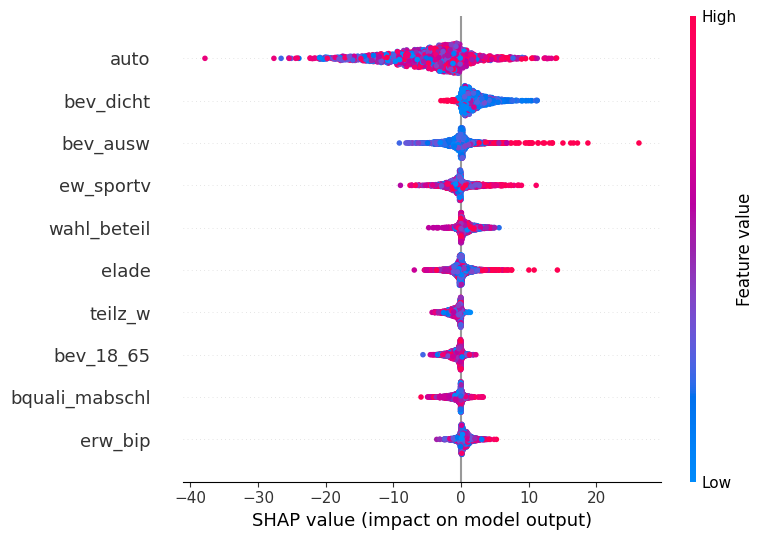

In [ ]:

from sympy import plot

shap.summary_plot(
    shap_values.squeeze(), # Squeezing because matmul error occurs if not squeezed
    instances_to_explain_data, 
    feature_names=feature_names,
    #plot_type="bar",
    max_display=10 
)


Generating a 4x3 grid of SHAP dependence plots for 10 features...


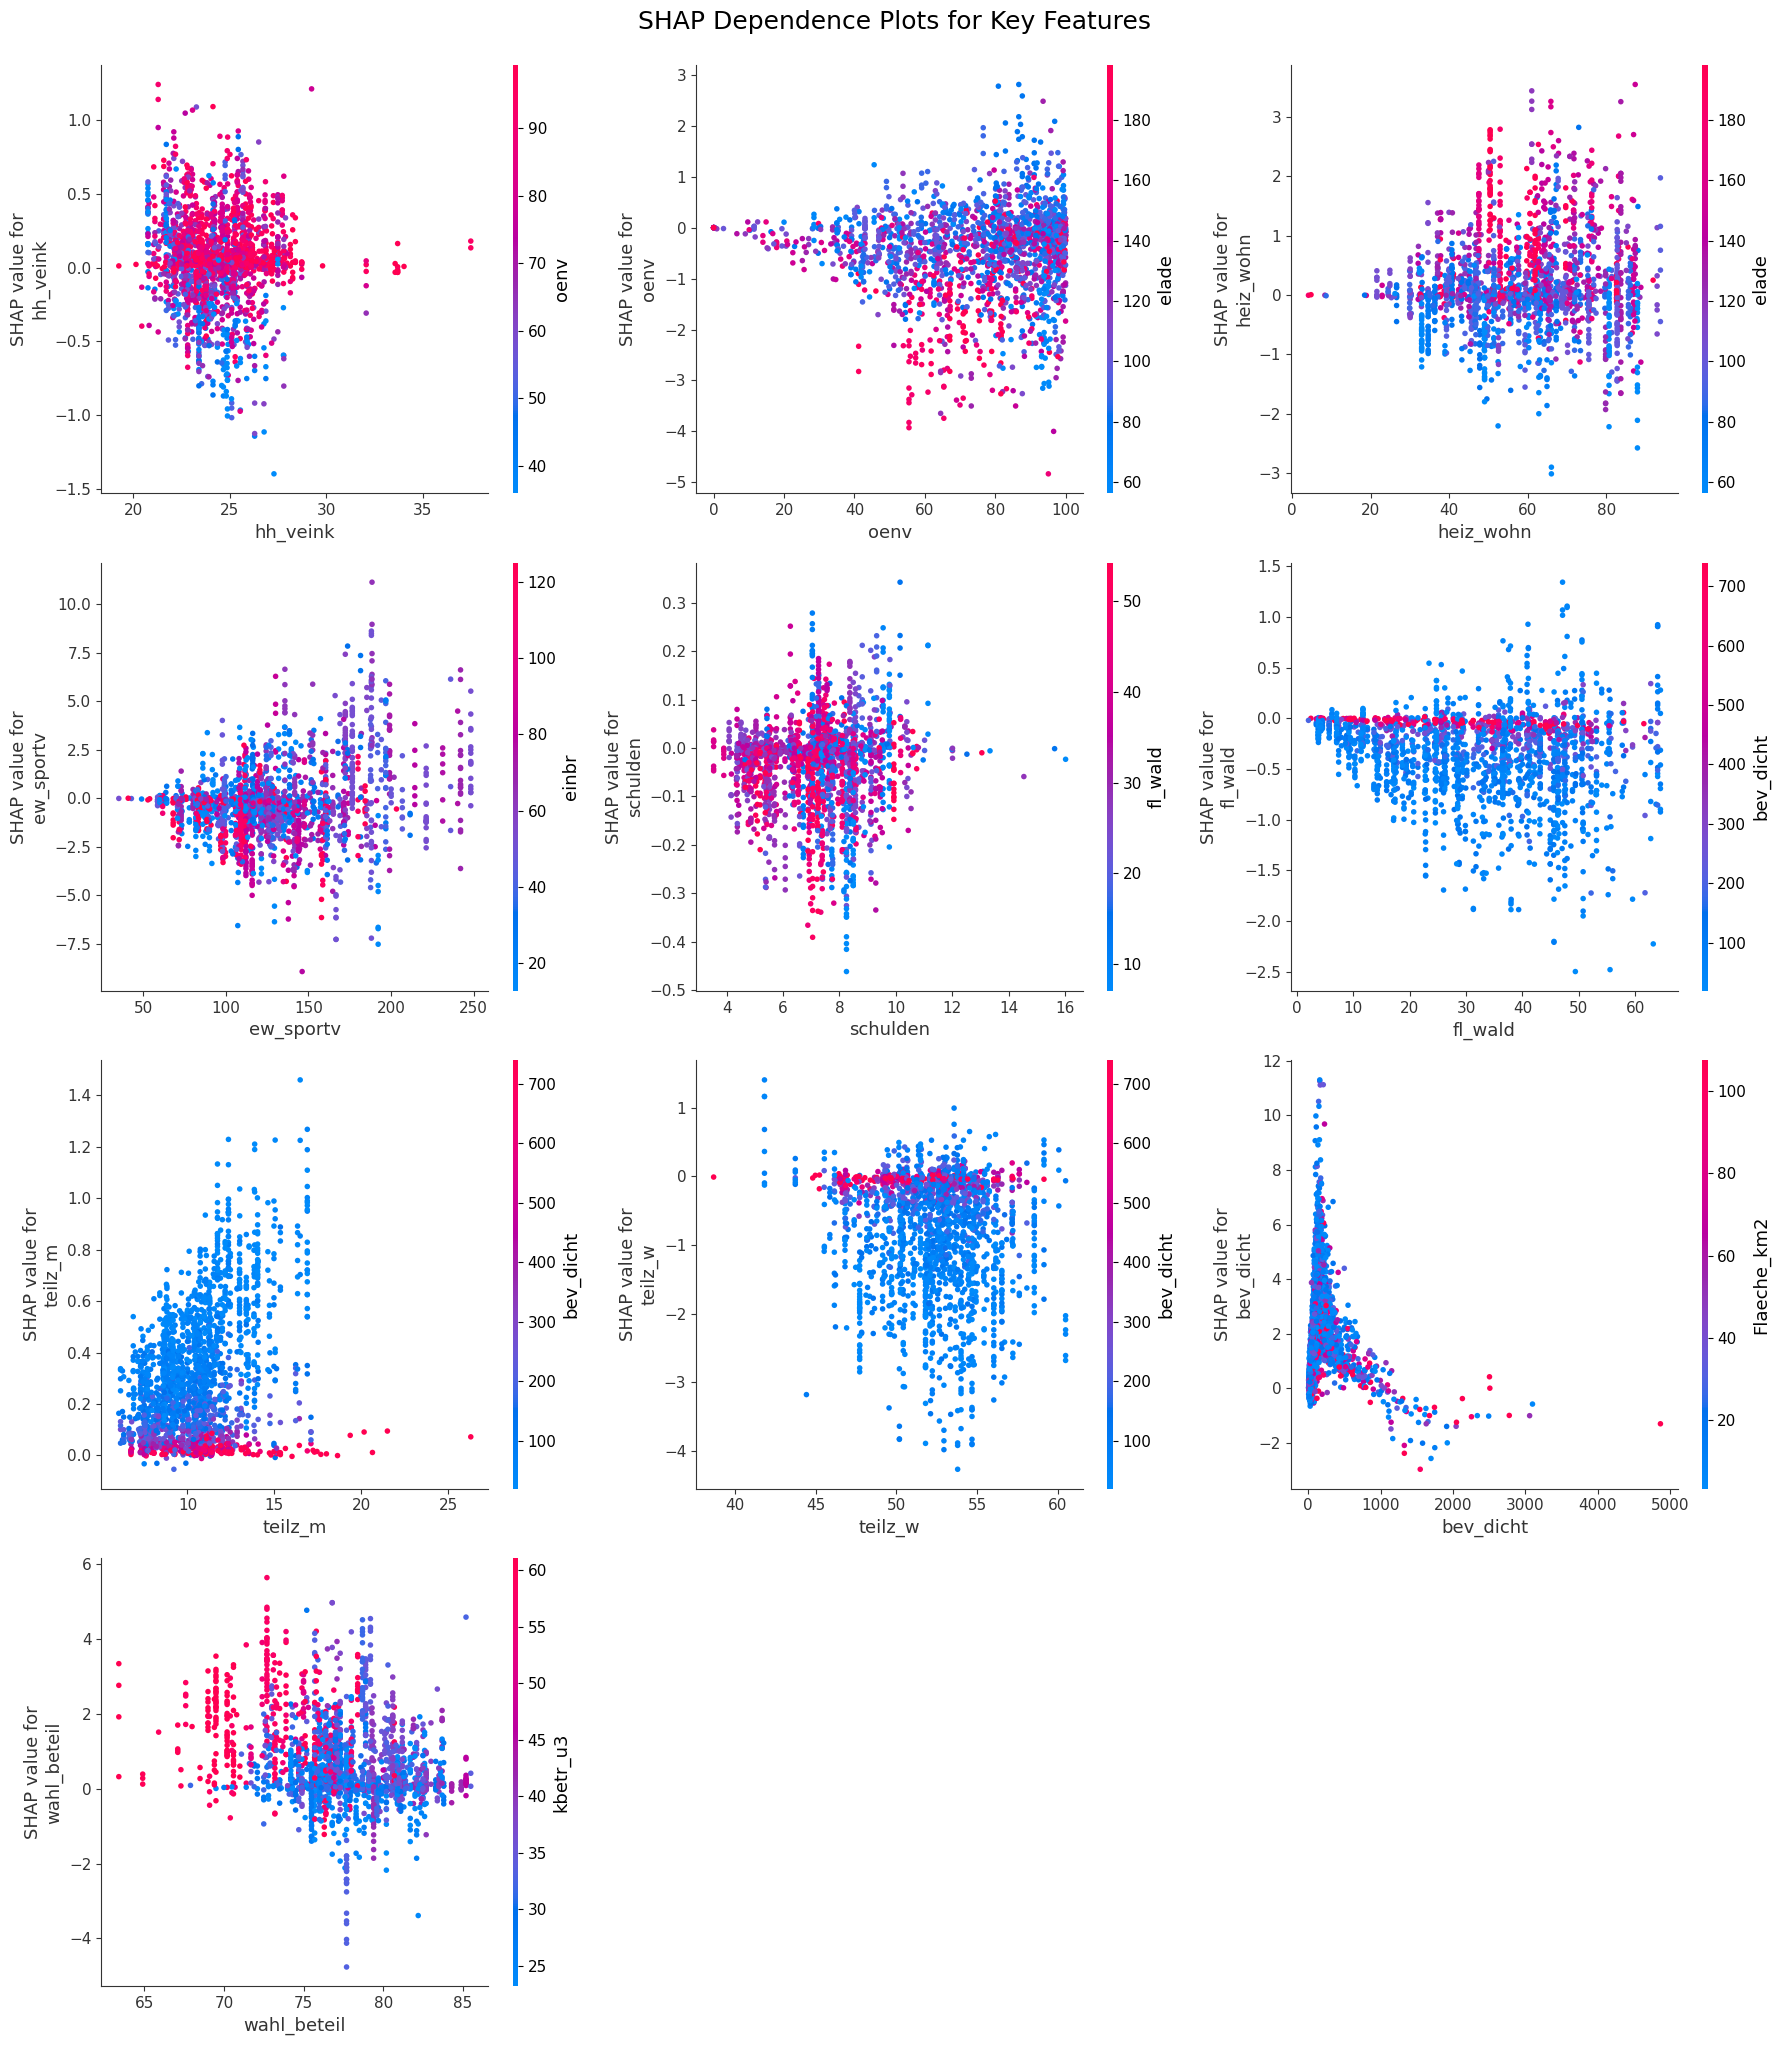

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

shap_values_squeezed = shap_values.squeeze()

selected_feature_names_for_dependence_plots = [
    'hh_veink',
    'oenv',
    'heiz_wohn',
    'ew_sportv',
    'schulden',
    'fl_wald',
    'teilz_m',
    'teilz_w',
    'bev_dicht',
    'wahl_beteil'
]

# Determine the grid dimensions (e.g., 3x4 or 4x3 depending on number of features)
num_plots = len(selected_feature_names_for_dependence_plots)
ncols = 3 # Number of columns in the grid
nrows = int(np.ceil(num_plots / ncols)) # Calculate number of rows needed

# Set up the matplotlib figure and axes for the grid
plt.figure(figsize=(ncols * 6, nrows * 5)) # Adjust figure size as needed (width, height)
# Each subplot will be managed by SHAP's plot function, so we just set up the figure

print(f"Generating a {nrows}x{ncols} grid of SHAP dependence plots for {num_plots} features...")

# Iterate through each selected feature and create a dependence plot
for i, feature_name_to_plot in enumerate(selected_feature_names_for_dependence_plots):
    try:
        # Find the index of the current feature
        feature_to_plot_index = feature_names.index(feature_name_to_plot)

        # Add a subplot to the figure
        ax = plt.subplot(nrows, ncols, i + 1) # (rows, columns, current_plot_number)

        # Generate the dependence plot. SHAP handles the axis labels and title.
        shap.dependence_plot(
            feature_to_plot_index,
            shap_values_squeezed,
            instances_to_explain_data,
            feature_names=feature_names,
            interaction_index="auto", # Automatically find the best interaction feature for each plot
            show=False,               # Do not show the plot immediately, let matplotlib manage it
            ax=ax                     # Pass the current subplot axis to SHAP
        )
        # Optional: Adjust title for clarity if needed, though shap.dependence_plot adds one
        # ax.set_title(f"SHAP Dependence for {feature_name_to_plot}", fontsize=12)

    except ValueError:
        print(f"Error: Feature '{feature_name_to_plot}' not found in feature_names. Skipping plot.")
        continue # Skip to the next feature

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()
plt.suptitle('SHAP Dependence Plots for Key Features', y=1.02, fontsize=18) # Overall title
plt.show()

In [ ]:
feature_name_to_plot = 'teilz_w' 

feature_to_plot_index = feature_names.index(feature_name_to_plot)

interaction_feature_name = 'bev_dicht' 

if interaction_feature_name: 
    interaction_index = feature_names.index(interaction_feature_name)
else:
    interaction_index = "auto" 

shap.dependence_plot(
    feature_to_plot_index,
    shap_values.squeeze(),
    instances_to_explain_data,
    feature_names=feature_names,
    interaction_index=interaction_index
)

# You can repeat this for other features of interest.

NameError: name 'feature_names' is not defined

In [ ]:
print(X_train_tensor.device)

# build predict function

In [83]:
import numpy as np
import torch

def predict_fn(x_np):
    # Scale input
    x_scaled = scaler.transform(x_np)
    x_tensor = torch.tensor(x_scaled, dtype=torch.float32).to(device)
    
    with torch.no_grad():
        preds = best_model(x_tensor).squeeze()
    
    return preds.cpu().numpy()


# Create the LIME Explainer

In [ ]:
from IPython.display import display

# Compare Bundesläder with LIME

In [86]:
def gkid_to_bundesland(gkid):
    prefix = str(gkid)[:2]
    if prefix == "14":
        return "Sachsen"
    elif prefix == "06":
        return "Hessen"
    else:
        return "Other"

bundesland_per_row = [gkid_to_bundesland(gkid) for gkid in gkid_series]


In [87]:
from sklearn.model_selection import train_test_split

X_train_unscaled, X_val_unscaled, y_train, y_val, bundesland_train, bundesland_val = train_test_split(
    df.values,
    y,
    bundesland_per_row,
    test_size=0.2,
    random_state=42
)


In [89]:
indices_bayern = [i for i, b in enumerate(bundesland_val) if b == "Sachsen"]
indices_mv = [i for i, b in enumerate(bundesland_val) if b == "Hessen"]

print(f"Sachsen instances: {len(indices_bayern)}")
print(f"Hessen instances: {len(indices_mv)}")


Sachsen instances: 79
Hessen instances: 70


In [90]:
def collect_lime_weights(indices, X_data, lime_explainer, predict_fn, num_features=10, num_samples=1000):
    all_explanations = []
    for idx in indices:
        row = X_data[idx]
        explanation = lime_explainer.explain_instance(
            data_row=row,
            predict_fn=predict_fn,
            num_features=num_features,
            num_samples=num_samples
        )
        contrib_dict = dict(explanation.as_list())
        all_explanations.append(contrib_dict)
    return all_explanations


In [91]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_unscaled,
    feature_names=feature_names,
    class_names=['Prediction'],
    mode='regression'
)


In [92]:
import lime
import lime.lime_tabular # Specific explainer for tabular data
lime_expls_bayern = collect_lime_weights(indices_bayern, X_val_unscaled, lime_explainer, predict_fn)
lime_expls_mv = collect_lime_weights(indices_mv, X_val_unscaled, lime_explainer, predict_fn)


In [93]:
import pandas as pd

def aggregate_contributions(lime_expls):
    df = pd.DataFrame(lime_expls)
    df = df.fillna(0)
    return df.abs().mean().sort_values(ascending=False)


In [94]:
agg_bayern = aggregate_contributions(lime_expls_bayern)
agg_mv = aggregate_contributions(lime_expls_mv)


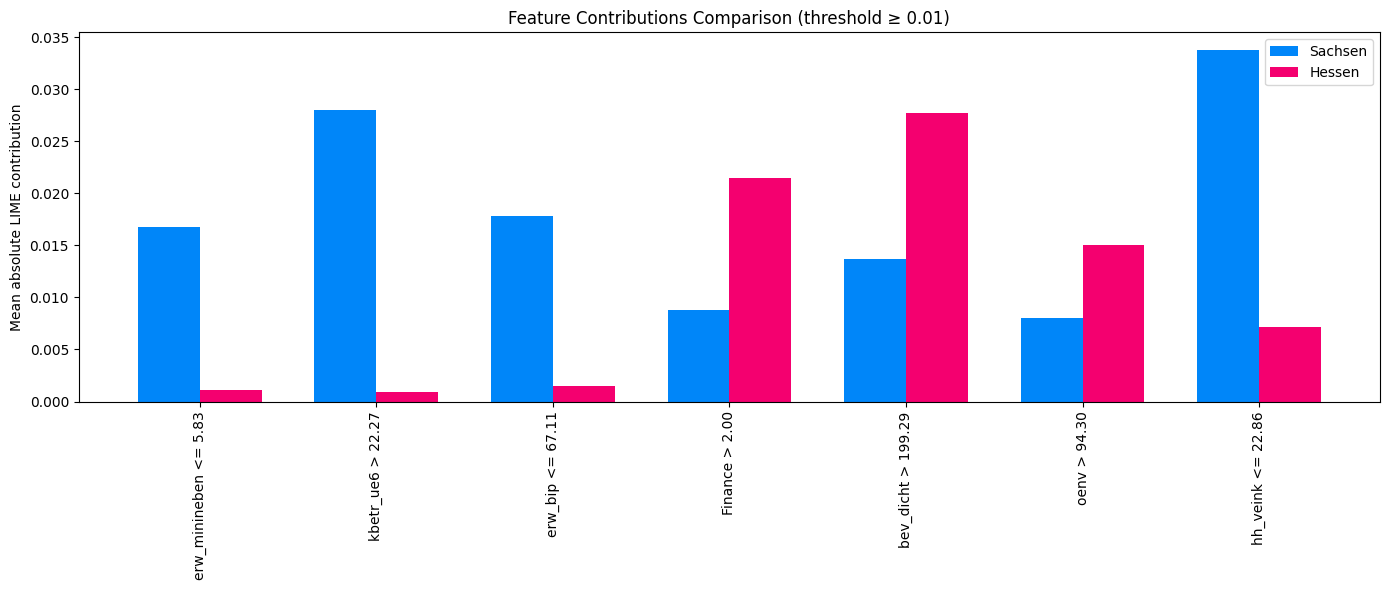

In [ ]:
import matplotlib.pyplot as plt

all_features = set(agg_bayern.index).union(set(agg_mv.index))

agg_bayern_aligned = agg_bayern.reindex(all_features, fill_value=0)
agg_mv_aligned = agg_mv.reindex(all_features, fill_value=0)

threshold = 0.015
mask = (agg_bayern_aligned.abs() >= threshold) | (agg_mv_aligned.abs() >= threshold)

# Filter the aggregated contributions based on the threshold
agg_bayern_filtered = agg_bayern_aligned[mask]
agg_mv_filtered = agg_mv_aligned[mask]

# Prepare x values for plotting
x = range(len(agg_bayern_filtered))
width = 0.35

# Plotting the filtered contributions
plt.figure(figsize=(14, 6))
plt.bar([i - width/2 for i in x], agg_bayern_filtered.values, width=width, label="Sachsen", color="#0086F9")
plt.bar([i + width/2 for i in x], agg_mv_filtered.values, width=width, label="Hessen", color="#F4006F")

plt.xticks(x, agg_bayern_filtered.index, rotation=90)
plt.ylabel("Mean absolute LIME contribution")
plt.title("Feature Contributions Comparison (threshold ≥ 0.01)")
plt.legend()
plt.tight_layout()
plt.show()
